In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import scipy.sparse as sp
import tinyarray
import kwant

In [2]:
def atan(y, x):
    ans = np.arctan2(y, x)
    if type ( x + 0.0) == type(y+0.0) and type(x+0.0) in [float, np.float64, np.float128, np.float_]:
    
        if ans < 0: return 2*np.pi + ans
        else: return ans
    
    elif type(x) == type(y) and type(x) == type(np.array([])) :
        ans[ans < 0] += 2*np.pi
        return ans
    
    else: raise TypeError("atan takes either floats or arrays")

# returns a boolean function which tests whether the vector is inside the regular polygon
def Regular_Polygon(r, n = 3, start = 0):
    if n < 3: raise RuntimeError("n >= 3")
    type_= "zigzag"
    def is_inside(point):
        x, y = point
        # y-=1
        if type_ == 'zigzag':y -=1
        angle = atan(y, x) - start
        angle %= (2*np.pi/n)
        alpha = (n - 2)/2/n*np.pi
        return np.sqrt(x*x + y*y) < np.sin(alpha)/np.sin(alpha + angle)*r
    return is_inside

# define graphene lattices
def create_graphene_tiangular_system(r, lam = 0.0, start = 0, a = 1.0, norb = 1, type_ = 'zigzag'):
    
    lat = kwant.lattice.honeycomb(a = a, norbs=norb)

    # create system
    sys = kwant.Builder()
    a_lat, b_lat = lat.sublattices

    def x():
        return
    x()

    # I will include the spin orbit effect using the four orbitals model

    # rather than simply single hopping, we will use 4 orbitals at each site, keeping in mind that 
    # S orbitals have 0 angular momentum, so we'll only include p orbitals, each with two spins
    # below is the onsite matrix

    #           |x, u>  |y, u>  |z, u>  |x, d>  |y, d>  |z, d>
    # |x, u>    0       -il/2   0       0       0       +l/2 
    # |y, u>    +il/2   0       0       0       0       -il/2
    # |z, u>    0       0       0       +l/2    -il/2   0
    # |x, d>    0       0       +l/2    0       +il/2   0
    # |y, d>    0       0       +il/2   -il/2   0       0
    # |z, d>    +l/2    +il/2   0       0       0       0

    E_C_S = -8.868*0 # just to get rid of the S energies, I am more interested in the P_z energies

    lamda = lam  # spin-orbit coupling constant
    t_onsite_CC = tinyarray.array([
        [ E_C_S,          0,           0,             0,         0,          0,           0,              0],
        [     0,          0, -1j*lamda/2,             0,         0,          0,           0,        lamda/2],
        [     0, 1j*lamda/2,           0,             0,         0,          0,           0,    -1j*lamda/2],
        [     0,          0,           0,             0,         0,    lamda/2, -1j*lamda/2,              0],
        [     0,          0,           0,             0,     E_C_S,          0,           0,              0],
        [     0,          0,           0,       lamda/2,         0,          0,  1j*lamda/2,              0],
        [     0,          0,           0,    1j*lamda/2,         0, -1j*lamda/2,          0,              0],
        [     0,    lamda/2,  1j*lamda/2,             0,         0,           0,          0,              0]
    ])

    # define the model parameters as in page 57
    t_ss = -6.769
    t_sp = 5.58
    t_pp_sig = 5.037
    t_pp_pi  = -2.8

    # overlap matrix elements, I will ignore them for starter
    s_ss = 0.212
    s_sp = -0.102
    s_pp_sig = -0.146
    s_pp_pi = 0.129

    # # Here I add the overlap matrix corrections, I approximates the overlap matrix as
    # # S ~~ I + S' where S' is has only the offdiagonal elements (diagonals are obviously 1)
    # # then I have the inverse being inv(S) ~~ I - S', I think this is valid given small S' elements
    # # which is kind of the case here

    # t_ss        -= t_ss*s_ss
    # t_sp        -= t_sp*s_sp
    # t_pp_sig    -= t_pp_sig*s_pp_sig
    # t_pp_pi     -= t_pp_pi*s_pp_pi

    t_hopping_CC = lambda nx, ny: tinyarray.array([
        [t_ss   ,  nx*t_sp                      ,                          ny*t_sp,           0,  0,  0,  0,  0],
        [nx*t_sp, nx*nx*t_pp_sig + ny*ny*t_pp_pi,       ny*nx*(t_pp_sig - t_pp_pi),           0,  0,  0,  0,  0],
        [ny*t_sp,     ny*nx*(t_pp_sig - t_pp_pi),   ny*ny*t_pp_sig + nx*nx*t_pp_pi,           0,  0,  0,  0,  0],
        [      0,                              0,                                0,     t_pp_pi,  0,  0,  0,  0],
        [0, 0, 0, 0, t_ss   ,                        nx*t_sp                      ,                         ny*t_sp,        0],
        [0, 0, 0, 0, nx*t_sp,                        nx*nx*t_pp_sig + ny*ny*t_pp_pi,      ny*nx*(t_pp_sig - t_pp_pi),       0],
        [0, 0, 0, 0, ny*t_sp,                            ny*nx*(t_pp_sig - t_pp_pi),  ny*ny*t_pp_sig + nx*nx*t_pp_pi,       0],
        [0, 0, 0, 0,       0,                                                     0,                               0, t_pp_pi]
    ])



    sys[lat.shape(Regular_Polygon(r, start=start), (0, 0))] = t_onsite_CC

    # sys[lat.neighbors()] = t_hopping_CC
    for hk in lat.neighbors():
        if hk.delta == np.array([0, 0]):
            sys[hk] = t_hopping_CC(0, 1)
        else:
            sys[hk] = t_hopping_CC(np.sqrt(3)/2, 1/2)

    # Count the number of connections (hopping terms) for the site
    for __ in range(2):     # make sure that no lattice point is connected to less than two sites
        sites = list(sys.sites())
        for s in sites:
            num_connections = sum(1 for _ in sys.neighbors(s))
            if num_connections == 1 or num_connections == 0: del sys[s]
    # Next we should add Hydrogen atoms (will be added later)

    # There is not spin orbit coupling on H orbitals, there is no spin in the S orbitals of H atom
    # For some reason, adding the hydrogen molecules was increasing the degeneracy rather than breaking it, until it 
    # is clear what the problem is, this will be commented
    # t_ss_H = -5.4
    # t_sp_H = 5.8
    # t_hopping_CH = lambda nx, ny: tinyarray.array([
    #     [t_ss_H,  nx*t_sp_H,    ny*t_sp_H,  0,0,0,0,0],
    #     [-nx*t_sp_H, 0,0,0,0,0,0,0],
    #     [-ny*t_sp_H, 0,0,0,0,0,0,0],
    #     [0,0,0,0,0,0,0,0],
    #     [0,0,0,0, t_ss_H,  nx*t_sp_H,ny*t_sp_H,  0],
    #     [0,0,0,0, -nx*t_sp_H, 0,0,0],
    #     [0,0,0,0, -ny*t_sp_H, 0,0,0],
    #     [0,0,0,0,0,0,0,0]
    # ])
    # E_H_S = -1.2
    # t_onsite_H = tinyarray.array([
    #     [E_H_S,0,0,0,0,0,0,0],
    #     [0,0,0,0,0,0,0,0],
    #     [0,0,0,0,0,0,0,0],
    #     [0,0,0,0,0,0,0,0],
    #     [0,0,0,0, E_H_S,0,0,0],
    #     [0,0,0,0,0,0,0,0],
    #     [0,0,0,0,0,0,0,0],
    #     [0,0,0,0,0,0,0,0]
    # ])

    # added_connections = []
    # # Add a site to each site that has only 2 connections
    # for site in sys.sites():
    #     num_connections = sum(1 for _ in sys.neighbors(site))
    #     if num_connections == 2:
    #         new_pos = site.pos
    #         for nsite in sys.neighbors(site):
    #             new_pos = new_pos + (site.pos - nsite.pos)
    #         new_site = kwant.lattice.Monatomic([[1, 0], [0, 1]], offset=new_pos, name="H", norbs=norb)(0, 0)
    #         added_connections.append((site, new_site, site.pos - nsite.pos))

    # for site, new_site, delta in added_connections:
    #     sys[new_site] = t_onsite_H      # On-site energy for hydrogen
    #     delta /= np.linalg.norm(delta)
    #     sys[site, new_site] = t_hopping_CH(np.abs(delta[0]), np.abs(delta[1]))  # Hopping between carbon and hydrogen

    return sys


In [3]:
def get_eigen_energies(sys: kwant.builder.FiniteSystem, n_max = None, plot = False,):
    h = sys.hamiltonian_submatrix(params=dict(), sparse=True)
    h.eliminate_zeros()
    if n_max is None:
        n_max = h.get_shape()[0] - 2
    enrgies = sla.eigsh(h.tocsc(), k=n_max, return_eigenvectors=False, which="SM")
    if plot:
        plt.scatter(range(len(enrgies)), sorted(enrgies))
        plt.xlabel('Index')
        plt.ylabel('Energy')
        plt.title('Eigenenergies')
        plt.show()
    return enrgies

In [4]:
def sorted_eigs(ev):
    evals, evecs = ev
    evals, evecs = map(np.array, zip(*sorted(zip(evals, evecs.transpose()))))
    return evals, evecs.transpose()

def separate_comp(wf):
    wavefunc = dict({
        "S_up": wf[0::8],
        "Px_up": wf[1::8],
        "Py_up": wf[2::8],
        "Pz_up": wf[3::8],
        "S_down": wf[4::8],
        "Px_down": wf[5::8],
        "Py_down": wf[6::8],
        "Pz_down": wf[7::8]
    })
    return wavefunc

def get_eigenstates(sys, n=None, n_max = None):
    h = sys.hamiltonian_submatrix(sparse = True)
    l = h.get_shape()[0]
    if n_max is None:
        n_max = l -2
    if n is None:
        n = np.array(list(range(l-2)))
    evals, evecs = sorted_eigs(sla.eigs(h.tocsc(), k = n_max, which='SM'))
    return evals[n], evecs.T[n]
    

In [5]:
def plot_current(syst, evec):

    # Calculate and plot the local current of the 10th eigenmode.
    J = kwant.operator.Current(syst)
    current = J(evec)
    kwant.plotter.current(syst, current, colorbar=False)

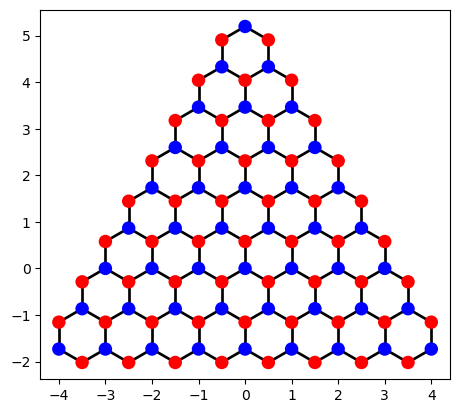

In [6]:
sys_t_zz = create_graphene_tiangular_system(6.5, start = np.pi/2, a = 1.0, norb=8, lam=0.0)
sys_t_zz2 = create_graphene_tiangular_system(6.5, start = np.pi/2, a = 1.0, norb=8, lam=0.1)
sys_t_zz3 = create_graphene_tiangular_system(6.5, start = np.pi/2, a = 1.0, norb=8, lam=5.0)
kwant.plot(sys_t_zz, site_color= lambda site: "k" if site.family.name=='H' else 'blue' if site.family.name=='0' else 'red')
plt.show()

In [7]:
for s  in sys_t_zz.sites():
    print(f"C\t{s.pos[0]}\t{s.pos[1]}\t0.0")

C	0.0	0.0	0.0
C	0.0	0.5773502691896258	0.0
C	1.0	0.0	0.0
C	0.5	-0.8660254037844386	0.0
C	-0.5	0.8660254037844386	0.0
C	-0.5	-0.28867513459481275	0.0
C	1.0	0.5773502691896258	0.0
C	0.5	-0.28867513459481275	0.0
C	-0.5	1.4433756729740645	0.0
C	0.5	0.8660254037844386	0.0
C	-1.0	0.0	0.0
C	0.5	1.4433756729740645	0.0
C	-1.0	0.5773502691896258	0.0
C	-0.5	-0.8660254037844386	0.0
C	-1.5	0.8660254037844386	0.0
C	1.0	2.309401076758503	0.0
C	0.0	-1.1547005383792515	0.0
C	-1.0	-1.7320508075688772	0.0
C	1.5	0.8660254037844386	0.0
C	-2.0	0.5773502691896258	0.0
C	-1.0	-1.1547005383792515	0.0
C	1.0	-1.7320508075688772	0.0
C	1.5	-0.8660254037844386	0.0
C	-1.5	1.4433756729740645	0.0
C	1.5	1.4433756729740645	0.0
C	-1.0	1.7320508075688772	0.0
C	0.0	1.7320508075688772	0.0
C	2.0	0.0	0.0
C	1.0	-1.1547005383792515	0.0
C	1.5	-0.28867513459481275	0.0
C	-1.5	-0.8660254037844386	0.0
C	1.0	1.7320508075688772	0.0
C	-1.0	2.309401076758503	0.0
C	0.0	2.309401076758503	0.0
C	0.0	-1.7320508075688772	0.0
C	-2.0	0.0	0.0
C	2

In [7]:
energies_t_zz = get_eigen_energies(sys_t_zz.finalized(), plot=False)
energies_t_zz2 = get_eigen_energies(sys_t_zz2.finalized(), plot=False)
energies_t_zz3 = get_eigen_energies(sys_t_zz3.finalized(), plot=False)

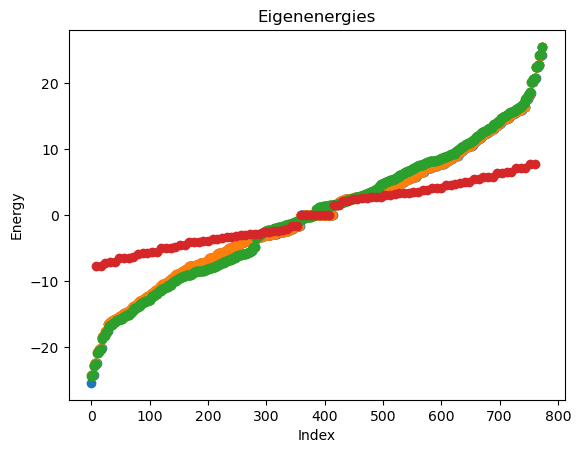

In [8]:
en_no_SO = np.load('graphene_tr_zz_noSOC.npy')
plt.scatter(range(len(energies_t_zz)), sorted(energies_t_zz))
plt.scatter(range(len(energies_t_zz2)), sorted(energies_t_zz2))
plt.scatter(range(len(energies_t_zz3)), sorted(energies_t_zz3))
plt.scatter(27*8/2*0 +8+ 8*np.array(range(len(en_no_SO))), sorted(en_no_SO)) # from 1 Band graphene simulation for comparison sake
plt.xlabel('Index')
plt.ylabel('Energy')
plt.title('Eigenenergies')
plt.show()